# Проект: Выбор локации для скважины.

## Описание проекта:

Для добывающей компании «ГлавРосГосНефть» нужно помочь решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищем месторождения, для каждого опредеим значения признаков.
- Строим модель и оцениваем объём запасов.
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины.
- Прибыль равна суммарной прибыли отобранных месторождений.


## Цели проекта:

Провести исследование с целью построения математической модели и определить регион, где добыча нефти принесёт наибольшую прибыль.

Результаты исследования позволят увеличить прибыль добывающей компании «ГлавРосГосНефть».


## Задачи проекта:

1. Загрузить и подготовить данные. Пояснить порядок действий.
2. Обучить и проверить модель для каждого региона:
* Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
* Обучить модель и сделать предсказания на валидационной выборке.
* Сохранить предсказания и правильные ответы на валидационной выборке.
* Напечатать на экране средний запас предсказанного сырья и RMSE модели.
* Проанализировать результаты.
3. Подготовится к расчёту прибыли:
* Все ключевые значения для расчётов сохранить в отдельных переменных.
* Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе. 
* Написать выводы по этапу подготовки расчёта прибыли.
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
* Выбрать скважины с максимальными значениями предсказаний. 
* Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
* Рассчитать прибыль для полученного объёма сырья.
5. Посчитать риски и прибыль для каждого региона:
* Применить технику *Bootstrap* с 1000 выборок, чтобы найти распределение прибыли.
* Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
* Написать выводы: предложить регион для разработки скважин и обоснуйте выбор.


## Проверяемые гипотезы:

Проверить гипотезу среди трёх регионов есть те, в которых вероятность убытков меньше 2.5%


## Описание данных:

Данные геологоразведки трёх регионов находятся в файлах: 
* geo_data_0.csv.
* geo_data_1.csv.
* geo_data_2.csv.

Признаки:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

Целевой признак:
* product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## 1. Загрузка и подготовка данных

In [1]:
# Все import соберем в начале проекта:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
from numpy.random import RandomState
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error


RANDOM_FIX_NUMBER = 12345  # Введем глобальную переменную для значения random_state
STATE = np.random.RandomState(RANDOM_FIX_NUMBER)

# Не ограничиваем максимальное количество отображающихся столбцов
pd.set_option('display.max_columns', None) 
# Настроим, чтобы числа в датасетах отражались с 3 знаками после запятой;
pd.set_option('display.float_format', '{:.3f}'.format) 
# вернуть настройки к дефолтным:
# pd.reset_option('all')

%config InlineBackend.figure_format = 'svg'

### 1.1. Загрузка локального и удаленного файла с данными:

Изучили файлы с предоставленными данными **geo_data_0.csv**, **geo_data_1.csv**, **geo_data_2.csv** и решили использовать символ **запятая** для разделения данных:

In [2]:
dataset_remote_path_0 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'
dataset_remote_path_1 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'
dataset_remote_path_2 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'

dataset_local_path_0 = 'datasets/geo_data_0.csv'
dataset_local_path_1 = 'datasets/geo_data_1.csv'  
dataset_local_path_2 = 'datasets/geo_data_2.csv'  

try:
    data0 = pd.read_csv(dataset_local_path_0, sep=',')
    data1 = pd.read_csv(dataset_local_path_1, sep=',')
    data2 = pd.read_csv(dataset_local_path_2, sep=',')
    print('Local datasets is loaded successfully.')
except:
    data0 = pd.read_csv(dataset_remote_path_0, sep=',')
    data1 = pd.read_csv(dataset_remote_path_1, sep=',')
    data2 = pd.read_csv(dataset_remote_path_2, sep=',')
    print('Remote datasets is loaded successfully.')

Local datasets is loaded successfully.


In [3]:
# Создадим список из датасетов:
data = [data0, data1, data2]  

### 1.2. Изучим датасеты:

Посмотрим, **что за данные находятся в изучаемых файлах:**

In [4]:
for i in range(3):
    print("Размер датасета data", i, ":", data[i].shape, "=", data[i].size)

Размер датасета data 0 : (100000, 5) = 500000
Размер датасета data 1 : (100000, 5) = 500000
Размер датасета data 2 : (100000, 5) = 500000


Размер файлов одинаковый.
Набор данных довольно большой: 100 000 строк х 5 столбцов.

Посмотрим, **какая информация содержится в столбцах:**

In [5]:
for i in range(3):
    print("\nИнформация по датасету data", i, ":\n", data[i].head())


Информация по датасету data 0 :
       id     f0     f1    f2  product
0  txEyH  0.706 -0.498 1.221  105.280
1  2acmU  1.335 -0.340 4.365   73.038
2  409Wp  1.023  0.152 1.420   85.266
3  iJLyR -0.032  0.139 2.979  168.621
4  Xdl7t  1.988  0.155 4.752  154.037

Информация по датасету data 1 :
       id      f0      f1     f2  product
0  kBEdx -15.001  -8.276 -0.006    3.179
1  62mP7  14.272  -3.475  0.999   26.953
2  vyE1P   6.263  -5.948  5.001  134.766
3  KcrkZ -13.081 -11.506  4.999  137.945
4  AHL4O  12.702  -8.147  5.004  134.766

Информация по датасету data 2 :
       id     f0     f1     f2  product
0  fwXo0 -1.147  0.963 -0.829   27.759
1  WJtFt  0.263  0.270 -2.530   56.070
2  ovLUW  0.195  0.289 -5.586   62.872
3  q6cA6  2.236 -0.554  0.930  114.573
4  WPMUX -0.516  1.716  5.899  149.601


Проверим, **названия столбцов на соответствие стилю *snake_case*:**

In [6]:
for i in range(3):
    columns = data[i].columns.tolist()
    print("\nНазвания столбцов в датасете data", i, ":\n", columns)


Названия столбцов в датасете data 0 :
 ['id', 'f0', 'f1', 'f2', 'product']

Названия столбцов в датасете data 1 :
 ['id', 'f0', 'f1', 'f2', 'product']

Названия столбцов в датасете data 2 :
 ['id', 'f0', 'f1', 'f2', 'product']


Все в порядке. **Названия столбцов в коррекции не нуждаются.**

**Поиск дубликатов:**

In [7]:
for i in range(3):
    print("Количество дублирующих строк в датасете data", i, ":", data[i].duplicated().sum())

Количество дублирующих строк в датасете data 0 : 0
Количество дублирующих строк в датасете data 1 : 0
Количество дублирующих строк в датасете data 2 : 0


Отлично! **Дубликатов в наших таблицах нет**.

Выведем **основную информацию с помощью метода info():**

In [8]:
for i in range(3):
    print(data[i].info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

Во всех 3-х датасетах идентичные типы данных:
* id — уникальный идентификатор скважины, состоящий из букв и цифр. Тип object - все правильно.
* f0, f1, f2 — три признака лпределенных скважин. Тип float64 - хорошо.
* product — объём запасов в скважине (тыс. баррелей). Тип float64 - замечательно.

**Удалим из датасетов столбцы id**, т.к. обозначения скважин не влияют на целевой признак product - объём запасов в скважине (тыс. баррелей):

In [9]:
for i in range(3):
    data[i] = data[i].drop('id', axis=1)

Изучим **пропущенные данные:**

In [10]:
for i in range(3):
    print("\nКоличество пропущенных данных в датасете data", i, ":")
    print(data[i].isna().sum())


Количество пропущенных данных в датасете data 0 :
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество пропущенных данных в датасете data 1 :
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество пропущенных данных в датасете data 2 :
f0         0
f1         0
f2         0
product    0
dtype: int64


Видим, что датасеты тщательно подготовлены. Мало того, что в каждом их них ровно 100 000 объектов, так и **пропусков ни в одном нет.**

Все признаки в датасетах - численные. **Категориальных признаков нет.** 

Для обучения моделей следует использовать линейную регрессию, поэтому **Масштабирование численных признаков проводить не нужно.**


### 1.3. Изучим наши данные на мультиколлинеарность признаков.
Посмотрим взаимную корреляцию признаков датасета на графике heatmap:

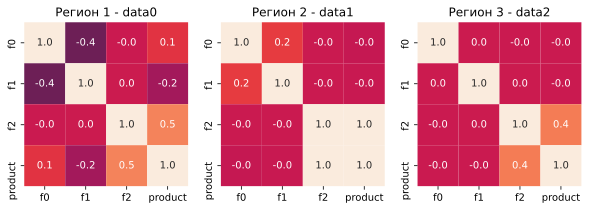

In [11]:
fig = plt.figure(figsize = (10,5))

name = ['Регион 1 - data0', 'Регион 2 - data1', 'Регион 3 - data2']
for i in range(3): 
    ax = fig.add_subplot(1, 3, i+1)
    sns.heatmap(data[i].corr(), ax=ax, square=True, annot=True, fmt='.1f', vmax=1, vmin=-1, cbar=False)
    ax.set_title(name[i])

Видим для датасета *data1* очень сильную, с коэффициентом корреляции Пирсона равным 1, зависимость между *f2* и *product* !

Для двух других датасетов эта зависимость тоже отмечена на уровне 0.4 и 0.5 - *"Умеренная линейная зависимость"*.


### 1.4. Визуальная оценка нормальности распределений.

Построим общую диаграммы для всех признаков всех трех датасетов:

<Figure size 1600x800 with 0 Axes>

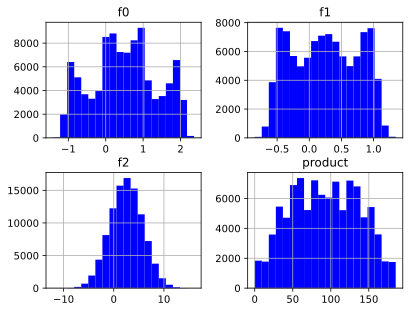

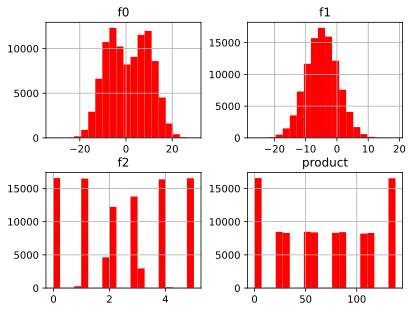

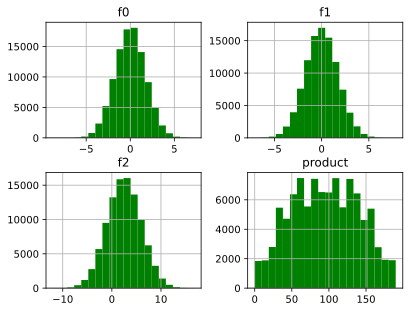

In [12]:
fig = plt.figure(figsize = (16,8));
colors = ['blue', 'red', 'green']
for i in range(3): 
    data[i].hist(bins=20, color=colors[i])

По гистограммам видно, что распределения данных в признаках сильно отличаются друг от друга для разных датасетов. Особенно сильно выделяются аномалии в данных столбцов *f2* и *product* в датасете *data1*, которые будут мешать процессу обучения.

### 1.5. Промежуточные выводы.

Для подготовки данных к последующей обработке были проведены следующие операции и сделаны следующие промежуточные выводы:

1. Загрузка по три локальных и удаленных файла с данными.
2. Проверено, что названия столбцов соответствуют стилю *snake_case*:
3. Выяснено, что дубликатов в нашем датасете нет.
4. Проверены типы данных.
5. Прогпущенных данных не обнаружено.
6. Удален признак *id* (уникальный идентификатор скважины), не влияющий на целевой признак *product* (объём запасов в скважине, в тыс. баррелей).
7. Изучены данные на мультиколлинеарность признаков. В датасете *data1* обнаружили очень сильную, с коэффициентом корреляции Пирсона равным 1, зависимость между *f2* и *product* !
8. Категориальных признаков нет.
9. Для обучения моделей следует использовать линейную регрессию, поэтому Масштабирование численных признаков проводить не нужно.

## 2. Обучение и проверка модели

Задачи, решаемые в разделе 2:

* Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
* Обучить модель и сделать предсказания на валидационной выборке.
* Сохранить предсказания и правильные ответы на валидационной выборке.
* Напечатать на экране средний запас предсказанного сырья и RMSE  модели.
* Проанализировать результаты.

In [13]:
# список предсказаний по объёму сырья в скважине на валидационной выборке
predictions_valid = []
# список правильных ответов на валидационной выборке
true_target = []
targets_valid = []

predictions_mean = []


def work_with_dataset(df):

# Выделим из переданного датасета
# обучающие признаки features и целевой признак target: 
    features = df.drop(["product"], axis=1)
    target = df["product"]
    
# Разобьём данные на обучающую и валидационную выборки в соотношении 75:25:    
    features_train, features_valid, target_train, target_valid = \
        train_test_split(features, target, test_size=0.25, random_state=STATE)

# Создадим и обучим модель:
    model = LinearRegression()
    model.fit(features_train, target_train)
    
# Cделаем предсказания на валидационной выборке:    
    predictions = model.predict(features_valid)

# список предсказаний по объёму сырья в скважине и список правильных ответов
    predictions_valid.append(predictions) 
#    predictions_valid.append(pd.Series(predictions))
    
    true_target.append(target_train.reset_index(drop=True))
    targets_valid.append(target_valid.reset_index(drop=True))
           
# Напечатаем средний запас предсказанного сырья и RMSE модели:  
    predictions_mean.append(round(predictions.mean(),0))
    print("Средний запас предсказанного сырья: {0:.2f} тыс. баррелей.". \
          format(predictions.mean()))
    print("RMSE модели: {0:.2f}.". \
          format((mean_squared_error(predictions, target_valid))**0.5))
    
    
for i in range(3):
    print("\nРегион", i+1, "  Датасет data", i, ":")
    work_with_dataset(data[i])    


Регион 1   Датасет data 0 :
Средний запас предсказанного сырья: 92.59 тыс. баррелей.
RMSE модели: 37.58.

Регион 2   Датасет data 1 :
Средний запас предсказанного сырья: 68.77 тыс. баррелей.
RMSE модели: 0.89.

Регион 3   Датасет data 2 :
Средний запас предсказанного сырья: 95.09 тыс. баррелей.
RMSE модели: 39.96.


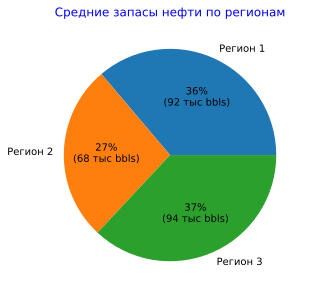

In [14]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.0f}%\n({:d} тыс bbls)".format(pct, absolute)

labels = ['Регион 1', 'Регион 2', 'Регион 3']
fig, ax = plt.subplots()
ax.pie(predictions_mean, labels=labels, 
       autopct = lambda pct: func(pct, predictions_mean),)
ax.set_title("Средние запасы нефти по регионам", color='blue')
plt.show();

**Промежуточные результаты**:
1. Разделены все данные на обучающую и валидационную выборки в соотношении 75:25.
2. Созданы и обучены модели *LinearRegression*.
3. Выполнены предсказания на валидационной выборке
4. Сделаны предсказания по объёму сырья в скважинах.
5. Созданы список предсказаний по объёму сырья *predictions_valid* и список правильных ответов *true_target* для каждого из регионов (predictions_valid[0], true_target[0])
6. Рассчитаны значения среднего запаса предсказанного сырья и RMSE моделей:
* для '*Регион 2 - Датасет data 1*', RMSE модели = 0.89. Столь низкие значения, видимо связаны с переобучением модели. Ведь корреляция между *f2* и *product* равна 1.0 ! 
* для '*Регион 1 - Датасет data 0*' и для '*Регион 3 - Датасет data 2*' получены значения RMSE  = 37.58 и RMSE  = 39.96. Это очень велико по сравнению с средним запасом предсказанного сырья и  говорит о сильном разбросе данных в валидационных выборках этих датасетов.
7. Для '*Регион 2 - Датасет data 1*' имеем самые низкие запасы предсказанного сырья. Всего 69 тыс баррелей против 93 - 95 для других регионов.

## 3. Подготовка к расчёту прибыли

Задачи, решаемые в разделе 3:
* Все ключевые значения для расчётов сохранить в отдельных переменных.
* Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
* Написать выводы по этапу подготовки расчёта прибыли.

Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Введем переменные:

In [15]:
# При разведке региона исследуют 500 точек:
NUMBER_POINTS = 500  
BEST_POINTS = 200    
# Бюджет на разработку скважин в регионе — 10 млрд рублей:
BUDGET = 1e07 # в тыс рублей  
# Доход с каждой единицы продукта:
COST_1_BARREL = 450 # в тыс рублей  
# Количество выборок для метода Bootstrap
NUM_CIRCLE_BOOTATRAP = 1000 

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [16]:
print("Точка безубыточности: {0:.0f} тыс. баррелей на каждый регион.\n". \
      format(BUDGET / COST_1_BARREL))
print("Средний объем нефти в скважине, требуемый для безубыточной работы: {0:.0f} тыс. баррелей.". \
      format(BUDGET / COST_1_BARREL /BEST_POINTS))

Точка безубыточности: 22222 тыс. баррелей на каждый регион.

Средний объем нефти в скважине, требуемый для безубыточной работы: 111 тыс. баррелей.


А предсказанные запасы по каждому региону:

In [17]:
df_result_predict = pd.DataFrame(columns=['Датасет',
                    'Средний запас предсказанного по валидационной выборке сырья (тыс. баррелей)']
)

for region in range(3):
    df_result_predict.loc[len(df_result_predict)] = \
        [f'регион_{region+1}:', 
         f'{predictions_valid[region].mean():.2f} < 111']

display(df_result_predict)


df_reserves = pd.DataFrame(columns=['Датасет',
                    'Среднее значение реального запасa сырья по полного кол-ву скважин в регионе (тыс. баррелей)']
)

for region in range(3):
    value = data[region]['product'].mean()
    df_reserves.loc[len(df_reserves)] = \
        [f'регион_{region+1}:', f'{value:.2f} < 111']

display(df_reserves)   

,Датасет,Средний запас предсказанного по валидационной выборке сырья (тыс. баррелей)
0,регион_1:,92.59 < 111
1,регион_2:,68.77 < 111
2,регион_3:,95.09 < 111


,Датасет,Среднее значение реального запасa сырья по полного кол-ву скважин в регионе (тыс. баррелей)
0,регион_1:,92.50 < 111
1,регион_2:,68.83 < 111
2,регион_3:,95.00 < 111


**Промежуточные результаты**:
* Среднее значение запаса сырья по всем скважинам для каждого из регионов меньше, чем точка безубыточности: 111 тыс. баррелей (объём сырья для безубыточной разработки новой скважины). 
* Разработку всех скважин вести нерентабельно.
* Из всех скважин нужно выбрать всего 200 лучших с максимальными запасами и вкладывать деньги в их запуск и производственную деятельность.

In [18]:
display(df_result_predict)
display(df_reserves)

,Датасет,Средний запас предсказанного по валидационной выборке сырья (тыс. баррелей)
0,регион_1:,92.59 < 111
1,регион_2:,68.77 < 111
2,регион_3:,95.09 < 111


,Датасет,Среднее значение реального запасa сырья по полного кол-ву скважин в регионе (тыс. баррелей)
0,регион_1:,92.50 < 111
1,регион_2:,68.83 < 111
2,регион_3:,95.00 < 111


## 4. Функция расчёта прибыли по выбранным скважинам и предсказаниям модели

Задачи, решаемые в разделе 4:

* Выбрать скважины с максимальными значениями предсказаний.
* Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
* Рассчитать прибыль для полученного объёма сырья.

Выберем для каждого региона лучшие 200 скважин по значению предсказанных запасов нефти:

In [19]:
# три списка с предсказанными запасами нефти:
predictions_valid

[array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
        118.18039721, 118.16939229]),
 array([54.23815201, 83.21787849,  2.97146723, ..., 83.90176874,
        -1.25947259, 26.16957032]),
 array([112.56187784,  69.46407333,  69.86622946, ..., 108.35059685,
        106.59141919, 124.86622084])]

In [20]:
# Создадим пустой датафрейм result, чтобы потом добавлять в него строками данные:
df_result_best_200 = pd.DataFrame(
            columns=['Регион',
            'Прибыль (млрд. руб)']
)

predict_200_best = [] # список с двумястами лучшими значениями запасов нефти 


# Функция расчёта прибыли
def calc_profit(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    target_selected = target[predictions_sorted.index][:BEST_POINTS]

    return target_selected.sum() * COST_1_BARREL - BUDGET


print("По 200-м лучшим скважинам:")
for region in range(3):
    predictions_sample = pd.Series(predictions_valid[region])      
    
    profit = calc_profit(targets_valid[region], predictions_sample)
    
    df_result_best_200.loc[len(df_result_best_200.index)] = \
        ["Регион " + str(i+1), profit/1000000]

display(df_result_best_200)  

По 200-м лучшим скважинам:


,Регион,Прибыль (млрд. руб)
0,Регион 3,3.321
1,Регион 3,2.415
2,Регион 3,2.540


**Промежуточные результаты**:

* Все три региона потенциально прибыльные.
* Для определения наиболее выгодного с точки зрения окупаемости вложений и рисков убытка проведём расчёт вероятности в следующем разделе.


## 5. Расчёт прибыли и рисков для каждого региона.

Задачи, решаемые в разделе 5:

* Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
* Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков.
* Написать выводы: предложить регион для разработки скважин и обоснуйте выбор.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,Датасет,Средняя прибыль от 200 лучших скважин (млн. руб.),95%-й доверительный интервал от 200 лучших скважин (млн. руб.),Риск убытков при 200 лучших скважин (%)
0,регион_1:,394,-69 ... 915,6.1
1,регион_2:,455,61 ... 856,0.7
2,регион_3:,354,-163 ... 848,7.6


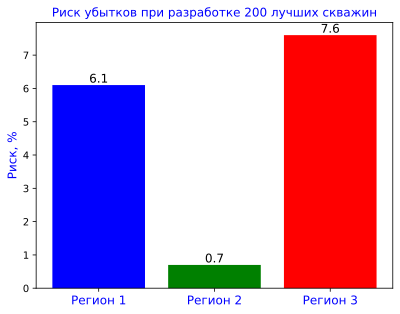

In [21]:
# Создадим пустой датафрейм result, чтобы потом добавлять в него строками данные:

#print("По 200-м лучшим скважинам:")

df_result = pd.DataFrame(
            columns=['Датасет',
            'Средняя прибыль от 200 лучших скважин (млн. руб.)', 
            '95%-й доверительный интервал от 200 лучших скважин (млн. руб.)', 
            'Риск убытков при 200 лучших скважин (%)']
)
Y = []

for region in range(3):
    predictions = predictions_valid[region]
    target = targets_valid[region]

    profit_values = []
    for i in tqdm(range(NUM_CIRCLE_BOOTATRAP)):
        # выбираем 500 скважин:
        target_sample  = target.sample(NUMBER_POINTS, replace=True, random_state=STATE)

        # выбираем соответствующие этим 500 скважинам предсказания:
        predictions_sample = predictions[target_sample.index]

        target_sample = target_sample.reset_index(drop = True)
        predictions_sample = pd.Series(predictions_sample)
        predictions_sample = predictions_sample.reset_index(drop = True)
              
        profit_values.append(calc_profit(target_sample, predictions_sample))
 
    profit_values = pd.Series(profit_values)
    mean_profit = (f'{round(profit_values.mean()/1000)}')
    confidence_interval = (f'{profit_values.quantile(0.025)/1000:.0f} ... ' 
                           f'{profit_values.quantile(0.975)/1000:.0f}') 
    risks = round((profit_values < 0).mean()*100, 1)
    Y.append(risks)    
   
    df_result.loc[len(df_result)] = [f'регион_{region+1}:', 
                                     mean_profit, confidence_interval, f'{risks}']
  
display(df_result)

# Строим гистограмму со значениями рисков.
X = ['Регион 1', 'Регион 2', 'Регион 3']
c = ['blue', 'green', 'red']
plt.bar(X, Y, color=c)

for i in range(3):
    plt.text(X[i], Y[i], float(Y[i]), 
             horizontalalignment='center', verticalalignment='bottom', 
             fontdict={'fontweight':500, 'size':12})

    plt.title("Риск убытков при разработке 200 лучших скважин", fontsize=12, color='blue')
plt.ylabel('Риск, %', fontsize=12, color='blue')
plt.gca().set_xticklabels(X, fontsize=12, color='blue')
plt.show()

**Промежуточные результаты**:
    
* Только лишь в **регионе 2** (файл с исходными данными: 'geo_data_1.csv') вероятность убытков меньше 2.5%. 
* Средняя прибыль в **регионе 2** составляет более 450 млн рублей.
* Для **региона 2** 95%-й доверительный интервал не содержит отрицательных значений.
* Интересно, что несмотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами (всего 69 тыс баррелей против 93 и 95 для других регионов.), средняя доходность со скважин во **регионе 2** прогнозируется выше других при наиме

## 6. Общий вывод

**По результатам исследования можно отметить следующие факты и сделать следующие выводы:**
  
1.Провести исследование с целью построения математической модели и определения одного их трёх регионов, в котором добыча нефти принесёт наибольшую прибыль.

2.Модель построена на данных по пробам нефти в трёх регионах: в каждом 100 000 месторождений, для каждого их которых были измерены качество нефти и объём её запасов.

3.Все данные были изучены и подготовлены к дальнейшим исследованиям. 

4.Построена модель по всему обэему данных после разделения на обучающую и валидационную выборки. Обнаружено:

In [22]:
df_reserves

,Датасет,Среднее значение реального запасa сырья по полного кол-ву скважин в регионе (тыс. баррелей)
0,регион_1:,92.50 < 111
1,регион_2:,68.83 < 111
2,регион_3:,95.00 < 111


* Среднее значение запаса сырья по полному количеству скважин для каждого из регионов меньше, чем точка безубыточности: 111 тыс. баррелей (объём сырья для безубыточной разработки новой скважины).
* Средний запас ресурсов по регионам недостаточен даже для окупаемости вложений на разработку.
* Принимается решение о том, что разработку сразу всех скважин вести нерентабельно.
* Из всех скважин нужно выбрать всего 200 лучших с максимальными запасами и вкладывать деньги в их запуск и производственную деятельность.

5.Проведена оценка по 200-м лучшим скважинам в каждом из регионов. Получены следующие результаты:

In [23]:
df_result_best_200

,Регион,Прибыль (млрд. руб)
0,Регион 3,3.321
1,Регион 3,2.415
2,Регион 3,2.540


Таким образом, по оценке 200 лучших скважин в каждом регионе сделан вывод: "Все три региона потенциально прибыльные".

6.Выполнены предсказания при помощи линейной регрессии, а так же применена технологиа *Bootstrap* с разделением каждого предсказанного значения прибыли по регионам на 1000 выборок.

In [24]:
df_result

,Датасет,Средняя прибыль от 200 лучших скважин (млн. руб.),95%-й доверительный интервал от 200 лучших скважин (млн. руб.),Риск убытков при 200 лучших скважин (%)
0,регион_1:,394,-69 ... 915,6.1
1,регион_2:,455,61 ... 856,0.7
2,регион_3:,354,-163 ... 848,7.6


7.Определен доверительный интервал получения прибыли в 95%.

8.Несмотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами (всего 69 тыс баррелей против 93 и 95), средняя доходность с 200 лучших скважин во **регионе 2** прогнозируется выше других, при наименьших рисках.

9.Наименьший риск получения убытков при разработке 200 скважин определен для *региона №2*. 

10.При величине запасов на уровне 69 (тыс. баррелей), по показателю наименьшего риска (<2.5%) c прибыльностью на уровне 450-460 (млн. руб.) выбирается модель разработки 200 скважин в *регионе №2* (файл с исходными данными: 'geo_data_1.csv').

[Вернутся к общему списку проектов курса “Data Science” Яндекс-практикума](../README.md)